In [46]:
import numpy as np
import matplotlib.pyplot as plt
import h5py, os, sys, glob, tqdm
import _pickle as pkl
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
recording_folder = '/Volumes/DATA7/autobahn/20211021_7214_ABC_g0'
stim_path      = os.path.join(recording_folder,'stim')
experimenter = 'djd'
experiment_description= 'for Hughes Lab collaboration on Autobahn Therepeutics remyelination therapy.'

# Pre-requisites:
- kilosort run on each probe
- phy curation, where some units marked good and some MUA 
- stimuli placed in a folder called 'stim' within each folder

### load stimulus information
this will be specific to each experimental paradigm. the below is for the autobahn stimulus.

In [48]:
glob.glob(stim_path+'/**')

['/Volumes/DATA7/autobahn/20211021_7214_ABC_g0/stim/2021-10-25-140423841815color_.pkl',
 '/Volumes/DATA7/autobahn/20211021_7214_ABC_g0/stim/2021-10-25-135209877880.pkl',
 '/Volumes/DATA7/autobahn/20211021_7214_ABC_g0/stim/211025135813-arbMatrix_highspeed-7414.pkl',
 '/Volumes/DATA7/autobahn/20211021_7214_ABC_g0/stim/211025141435-gratings_color-7414.pkl',
 '/Volumes/DATA7/autobahn/20211021_7214_ABC_g0/stim/211025134650-gratings_orientation-7414.pkl',
 '/Volumes/DATA7/autobahn/20211021_7214_ABC_g0/stim/211025135205-scene_flicker_shuffled-7414.pkl']

In [49]:
gratings_pkl = pkl.load(open(glob.glob(stim_path+'/*gratings*')[0],'rb'))
scene_pkl = pkl.load(open(glob.glob(stim_path+'/*scene*')[0],'rb'))
arbMatrixcolor_pkl = pkl.load(open(glob.glob(stim_path+'/*color_*')[0],'rb'))
arbMatrix_pkl = pkl.load(open(glob.glob(stim_path+'/*highspeed*')[0],'rb'))
arbMatrix_matrix = pkl.load(open(np.sort(glob.glob(stim_path+'/*'))[0],'rb'))
gratings_color_pkl = pkl.load(open(glob.glob(stim_path+'/*gratings_c*')[0],'rb'))

#stimulus list
stimuli = {'luminance_flash':None,
           'gratings':gratings_pkl,
           'gratings_color':gratings_color_pkl,
           'natural_scenes':scene_pkl,
           'spatiochromatic_noise':arbMatrixcolor_pkl,
            'spatioluminance_noise':arbMatrix_matrix}

parse stimulus information.
this currently takes ~2X recording time, for some reason. need to fix

In [50]:
if not os.path.exists(os.path.join(recording_folder,'digital_lines_rising_samples.pkl')):
    #spikeGLX. ignore this cell if data is from Open Ephys GUI 
    nidaq_bin = '/Volumes/s1/autobahn/20210922_3592_ABC_g0/20210922_3592_ABC_g0_t0.nidq.bin'
    mm = np.memmap(nidaq_bin,dtype=np.uint16)
    digital_words = mm[8::9]
    num_digital_channels=8 # TODO: update to get this from .meta file; from niXDChans
    digital_lines_rising = {}
    digital_lines_falling = {}
    for i in tqdm.tqdm(range(digital_words.shape[0])[::10]): #note that this downsamples by factor 10, to 100kHz
        if i==0:
            state_previous_sample = '{0:08b}'.format(digital_words[i])
            for line in range(num_digital_channels):
                digital_lines_rising['D'+str(line)] = [] #initialize empty list
                digital_lines_falling['D'+str(line)] = [] #initialize empty list
        else:
            state_this_sample = '{0:08b}'.format(digital_words[i])
            changes = [j for j in range(len(state_previous_sample)) if state_previous_sample[j] != state_this_sample[j]]
            for line in changes:   
                    if state_this_sample[line] == '1':
                        digital_lines_rising['D'+str(line)].extend([i*10]) #note that this scales back up to 1MHz sampling rate 
                    else:
                        digital_lines_falling['D'+str(line)].extend([i*10])  #note that this scales back up to 1MHz sampling rate 
            state_previous_sample=state_this_sample #update sample
    digital_lines_rising2 = {}
    digital_lines_falling2 = {}
    for i,key in enumerate(digital_lines_rising.keys()):
        digital_lines_rising2['D'+str(7-i)]=np.array(digital_lines_rising[key])/10000000.
        digital_lines_falling2['D'+str(7-i)]=np.array(digital_lines_falling[key])/10000000.
    pkl.dump(digital_lines_rising2,open(os.path.join(recording_folder,'digital_lines_rising_samples.pkl'),'wb'))
    pkl.dump(digital_lines_falling2,open(os.path.join(recording_folder,'digital_lines_falling_samples.pkl'),'wb'))
else:
    digital_lines_rising2 = pkl.load(open(os.path.join(recording_folder,'digital_lines_rising_samples.pkl'),'rb'))
    digital_lines_falling2= pkl.load(open(os.path.join(recording_folder,'digital_lines_falling_samples.pkl'),'rb'))

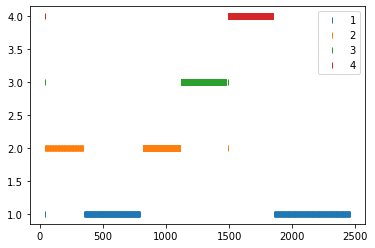

In [51]:
for ch in ([1,2,3,4]):
    plt.plot(np.array(digital_lines_rising2['D'+str(ch)]),
             np.ones(len(digital_lines_rising2['D'+str(ch)]))*ch,
             '|',label=ch)
plt.legend()

In [52]:
flashes_times = digital_lines_rising2['D2'][1:np.where(np.diff(digital_lines_rising2['D2'])>50.)[0][0]+1]
gratings_times= digital_lines_rising2['D1'][1:221]
gratings_color_times= digital_lines_rising2['D1'][222:]
scenes_times= digital_lines_rising2['D2'][np.where(np.diff(digital_lines_rising2['D2'])>50.)[0][0]+1:-1]
highspeed_times = digital_lines_rising2['D3'][1:-1]
color_times = digital_lines_rising2['D4'][1:]

In [53]:
color_times

array([1488.21357, 1488.25566, 1488.30556, ..., 1848.03612, 1848.08624,
       1848.13603])

In [54]:
if np.shape(color_times)[0]!=7200 \
    or np.shape(highspeed_times)[0]!=7200\
    or np.shape(scenes_times)[0]!=len(stimuli['natural_scenes']['bgsweeporder'])\
    or np.shape(gratings_times)[0]!=220\
    or np.shape(flashes_times)[0]!=100:
    print('problem. '+str(np.shape(highspeed_times)[0]))
else:
    stimuli_times = {'luminance_flash':flashes_times,
                       'gratings':gratings_times,
                     'gratings_color':gratings_color_times,
                       'natural_scenes':scenes_times,
                       'spatiochromatic_noise':color_times,
                        'spatioluminance_noise':highspeed_times}

### load sorted units

In [55]:
from dlab.nwbtools import df_from_phy, load_phy_template, option234_positions, multi_load_unit_data
import pandas as pd

In [56]:
#spikeglx
probes = [os.path.basename(f) for f in np.sort(glob.glob(recording_folder+'/*imec*'))]
probeids = ['A','B','C'] 
probedepths = [1200,1200,1250] 

In [57]:
probes

['20211021_7214_ABC_g0_imec0',
 '20211021_7214_ABC_g0_imec1',
 '20211021_7214_ABC_g0_imec2']

In [61]:
unit_dfs = []
for i,probe in enumerate(probes):
    #make a units DataFrame
    units = load_phy_template(os.path.join(recording_folder,probe))
    df = pd.DataFrame.from_dict(units,orient='index')
    df['probe'] = [probeids[i]]*df.shape[0]
    df['depth'] = np.array(df['ypos']-3840)+probedepths[i]
    #waveform
    unit_dfs.extend([df])

In [62]:
df_units = pd.concat(unit_dfs)

In [63]:
df_units.head()

,samples,times,template,waveform_weights,xpos,ypos,label,KSlabel,KSamplitude,KScontamination,probe,depth
0,"[1091057, 1097745, 1744032, 2167195, 3066766, ...","[36.368566666666666, 36.5915, 58.1344, 72.2398...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 1.0], [0.6417236709716453, 0.6417236709...",32.394678,3810.346417,good,good,938.2,100.0,A,1170.346417
1,"[839076, 4099712, 5937081, 6135197, 8581472, 9...","[27.9692, 136.65706666666668, 197.9027, 204.50...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 1.0], [0.5274143916747788, 0.5274143916...",27.001167,3780.368758,good,good,456.4,100.0,A,1140.368758
2,"[4406, 13861, 32863, 35574, 40690, 41047, 4198...","[0.14686666666666667, 0.46203333333333335, 1.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 1.0], [0.6616849499895592, 0.6616849499...",29.138833,3791.394793,mua,mua,744.4,124.8,A,1151.394793
3,"[2959393, 2961614, 4375148, 5435864, 6257236, ...","[98.64643333333333, 98.72046666666667, 145.838...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 1.0], [0.8984060060041581, 0.8984060060...",27.812208,3705.415287,mua,mua,312.7,0.0,A,1065.415287
4,"[378, 617, 681, 1583, 1802, 2094, 3090, 32147,...","[0.0126, 0.020566666666666667, 0.0227, 0.05276...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 1.0], [0.823921297539701, 0.82392129753...",28.561772,3683.311407,mua,mua,359.5,59.0,A,1043.311407


do unit quailty analysis; add to df

In [ ]:
# print('PCA quality took '+str(time.time()-t0)+' sec');t0 = time.time()
# isiV = sq.isiViolations(directory,time_limits)

## Assemble NWB

In [85]:
import pynwb
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.utils import StrDataset

In [86]:
from datetime import datetime
from dateutil.tz import tzlocal
from pynwb import NWBFile

nwbfile = NWBFile('Autobahn_myelin', 
                  recording_folder, 
                  datetime.now(tzlocal()),
                  experimenter=experimenter,
                  lab='Denman Lab',
                  institution='University of Colorado',
                  experiment_description=experiment_description,
                  session_id=os.path.basename(recording_folder))

### add stimulus information

In [88]:
stimuli_times.keys()

dict_keys(['luminance_flash', 'gratings', 'gratings_color', 'natural_scenes', 'spatiochromatic_noise', 'spatioluminance_noise'])

In [89]:
for stim in stimuli_times.keys():
    nwbfile.add_epoch(stimuli_times[stim][0], 
                      stimuli_times[stim][-1]+3.,
                      [stim])

In [90]:
nwbfile.add_trial_column('stimulus', 'the stimulus during this trial')
nwbfile.add_trial_column('stimulus_info', 'the stimulus descriptor')

lums = ['white','black']
stim = 'luminance_flash'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=[lums[i%2]])

stim = 'gratings'
info = [stimuli[stim]['bgsweeptable'][ind] for ind in stimuli[stim]['bgsweeporder']]
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=[info[i]])

stim = 'natural_scenes'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=[stimuli[stim]['bgsweeporder'][i]])

stim = 'spatiochromatic_noise'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=[stimuli['spatiochromatic_noise']['stackG'][i].tolist(),stimuli['spatiochromatic_noise']['stackB'][i].tolist()])

stim = 'spatioluminance_noise'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=stimuli['spatioluminance_noise'][i].tolist())

### add ephys data
first add electrodes and raw data link

In [91]:
device = nwbfile.create_device(name='DenmanLab_EphysRig1')
for i, probe in enumerate(probes):
    electrode_name = 'probe'+str(i)
    description = "Neuropixels1.0_"+probeids[i]
    location = "primary visual cortex"

    electrode_group = nwbfile.create_electrode_group(electrode_name,
                                                     description=description,
                                                     location=location,
                                                     device=device)
    
    #add channels to each probe
    for ch in range(option234_positions.shape[0]):
        nwbfile.add_electrode(x=option234_positions[ch,0],y=0.,z=option234_positions[0,1],imp=0.0,location='none',filtering='high pass 300Hz',group=electrode_group)
    
#     if len(glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')) > 0:
#         ephys_ts = pynwb.ecephys.ElectricalSeries('lfp_probe'+probeids[i],
#                                 data=H5DataIO(data=StrDataset(glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')[0]),    
#                                         link_data=True),
#                                 electrodes = electrode_group,
#                                 starting_time=0,
#                                 rate=2500,
#                                 resolution=0.001,
#                                 comments="V1, depth = 1500um",
#                                 description="V1, depth = 1500um")
#         nwbfile.add_acquisition(ephys_ts)

In [81]:
#dummy
nwbfile.add_electrode(x=0.,y=0.,z=0.,imp=10.0,location='none',filtering='some',group=electrode_group)

In [82]:
electrode_table_region = nwbfile.create_electrode_table_region([0], 'the second and third electrodes')

then add sorted units

In [43]:
# df_units.rename(columns = {'ypos':'zpos'}, inplace = True)

In [92]:
# nwbfile.add_unit_column('location', 'the anatomical location of this unit')
# nwbfile.add_unit_column('quality', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_ISIviolations', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_sn', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_distance', 'the quality for the inference of this unit')
nwbfile.add_unit_column('depth', 'the depth of this unit from the pia')
nwbfile.add_unit_column('xpos', 'the x position on probe')
nwbfile.add_unit_column('ypos', 'the z position on probe')
# nwbfile.add_unit_column('template', 'Kilosort template')
nwbfile.add_unit_column('label', 'user label')
nwbfile.add_unit_column('KSlabel', 'Kilosort label')
nwbfile.add_unit_column('KSamplitude', 'Kilosort amplitude')
nwbfile.add_unit_column('KScontamination', 'Kilosort ISI contamination')
nwbfile.add_unit_column('probe', 'probe ID')

for i,unit_row in df_units.iterrows():
    nwbfile.add_unit(id=int(unit_row.name), 
                     spike_times=unit_row.times,
                     electrodes = np.where(unit_row.waveform_weights > 0)[0],
#                      waveform_mean = #(time,electrodes)
#                       quality=0.95
                     depth = unit_row.depth,
                     xpos= unit_row.xpos,
                     ypos= unit_row.ypos,
#                      template= unit_row.template,
                     label= unit_row.label,
                     KSlabel= unit_row.KSlabel,
                     KSamplitude= unit_row.KSamplitude,
                     KScontamination= unit_row.KScontamination,
                     probe= unit_row.probe)

#### add lfp data


In [26]:
lfp_data_path = glob.glob(os.path.join(recording_folder,probes[1])+'/*.lf.bin')[0]

In [27]:
from pynwb import TimeSeries

data = np.memmap(lfp_data_path,dtype=np.uint16).reshape(-1,385)

wrapped_data = H5DataIO(data=data, compression=True)     # <----

test_ts = TimeSeries(name='lfp_imec1_compressed_timeseries',
                     data=wrapped_data,                  # <----
                     unit='SIunit',
                     timestamps=np.linspace(0,(1/2500.*data.shape[0]),data.shape[0]))
nwbfile.add_acquisition(test_ts)

In [28]:
lfp_data_path = glob.glob(os.path.join(recording_folder,probes[2])+'/*.lf.bin')[0]
from pynwb import TimeSeries

data = np.memmap(lfp_data_path,dtype=np.uint16).reshape(-1,385)

wrapped_data = H5DataIO(data=data, compression=True)     # <----

test_ts = TimeSeries(name='lfp_imec2_compressed_timeseries',
                     data=wrapped_data,                  # <----
                     unit='SIunit',
                     timestamps=np.linspace(0,(1/2500.*data.shape[0]),data.shape[0]))
nwbfile.add_acquisition(test_ts)

In [29]:
lfp_data_path = glob.glob(os.path.join(recording_folder,probes[0])+'/*.lf.bin')[0]
from pynwb import TimeSeries

data = np.memmap(lfp_data_path,dtype=np.uint16).reshape(-1,385)

wrapped_data = H5DataIO(data=data, compression=True)     # <----

test_ts = TimeSeries(name='lfp_imec0_compressed_timeseries',
                     data=wrapped_data,                  # <----
                     unit='SIunit',
                     timestamps=np.linspace(0,(1/2500.*data.shape[0]),data.shape[0]))
nwbfile.add_acquisition(test_ts)

#### optionally add behavior

In [30]:
if len(glob.glob(os.path.join(recording_folder,'behavior*')))>0:
    pass #TODO
else: print('no behavior data found')

no behavior data found


#### optionally add eyetracking

In [31]:
if len(glob.glob(os.path.join(recording_folder,'eyetrack*')))>0:
    pass #TODO
else: print('no eyetracking data found')

no eyetracking data found


# Write NWB

In [93]:
nwb_path = os.path.join(recording_folder,os.path.basename(recording_folder))+'_2.nwb'
with pynwb.NWBHDF5IO(nwb_path, 'w') as io:
    io.write(nwbfile)

<br>
<br>
<br>
<br>
<br>

# Read NWB

In [ ]:
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget
import h5py, glob, os
import numpy as np
import matplotlib.pyplot as plt

# nwb_path = '/Volumes/DATA7/autobahn/20210923_3593_ABC_g0/20210923_3593_ABC_g09.nwb'
io = NWBHDF5IO(nwb_path, mode='r')
nwb_ = io.read()

nwb2widget(nwb_)